In [1]:
import zxing

def scan_barcode(image_path):
    # Create a ZXing reader
    reader = zxing.BarCodeReader()

    # Decode the barcode
    barcode = reader.decode(image_path)

    # Check if a barcode was found
    if barcode:
        s_barcode=barcode.parsed
        print(f"Found barcode: {barcode.parsed}")
    else:
        print("No barcode found")
    return s_barcode

# Set the path for the image you want to scan
barcode=scan_barcode('box_cola_dose_cola_drink_brand_erfrischungsgetr_nk_coca_cola_red-913926.jpg!d.jpeg')


Found barcode: 5449000000996


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Using TensorFlow backend.


In [7]:
import requests

def get_product_info(barcode):
    """Fetches comprehensive product information from Open Food Facts API (v2).

    Args:
        barcode (str): The barcode of the product to retrieve information for.

    Returns:
        dict (or None): A dictionary containing product details if found, or None
                         if the API request fails or product is not found.

    Raises:
        requests.exceptions.RequestException: If an error occurs during the API request.
    """

    url = f"https://world.openfoodfacts.org/api/v2/product/{barcode}.json"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for non-200 status codes

        data = response.json()

        if data['status'] == 1:  # Product found
            product = data['product']

            # Extract product details
            product_info = {
                "product_name": product.get('product_name', 'No name available'),
                "brand": product.get('brands', 'No brand available'),
                "generic_name": product.get('generic_name', 'No description available'),
                "image_url": product.get('image_url', None),
                "ingredients": product.get('ingredients', None),
                "allergens": product.get('allergens', None),
                "categories": product.get('categories', None),
                "labels": product.get('labels', None),
                # Include additional fields as needed
                # ...
            }

            # Extract all nutritional values dynamically
            nutrients = product.get('nutriments', {})
            product_info["nutritional_info"] = {}
            for key, value in nutrients.items():
                if '_100g' in key:
                    formatted_key = key.replace('_100g', '').replace('_', ' ').capitalize()
                    product_info["nutritional_info"][formatted_key] = value

            return product_info

        else:
            print(f"Product not found in Open Food Facts database.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

def generate_insight(product_info, user_preferences):
    """Generates insights about a product based on its nutritional data and user preferences.

    Args:
        product_info (dict): A dictionary containing product information, as returned by get_product_info().
        user_preferences (str): A string representing user preferences.

    Returns:
        str: A string containing the generated insights.
    """

    # Extract product name and nutritional data from product_info
    product_name = product_info.get('product_name', 'No name available')
    nutritional_data = product_info.get('nutritional_info', {})

    # Combine the product name and nutritional data into a prompt
    prompt = f"The product '{product_name}' has the following nutritional information:\n"
    for key, value in nutritional_data.items():
        prompt += f"{key}: {value}\n"

    # Add user preferences
    if user_preferences:
        prompt += f"\nBased on the following preferences: {user_preferences}, can you provide insights on whether this product is a good choice for health and sustainability?"

    # Use the LLaMA model to generate insights
    insights = pipe(prompt, max_length=2000)

    # Return the generated text
    return insights[0]['generated_text']

# # Example usage
# barcode = "YOUR_BARCODE_HERE"  # Replace with the actual barcode
product_data = get_product_info(barcode)

if product_data:
    user_preferences = "I prefer low-sugar, low-sodium products and want to avoid high-sugar drinks."
    insight_text = generate_insight(product_data, user_preferences)
    print(insight_text)
else:
    print("\nNo product data retrieved.")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The product 'Coca-Cola' has the following nutritional information:
Caffeine: 0.0097
Carbohydrates: 10.6
Energy-kcal: 42
Energy-kj: 180
Energy: 180
Fat: 0
Fruits-vegetables-legumes-estimate-from-ingredients: 0
Fruits-vegetables-nuts-estimate-from-ingredients: 0
Nova-group: 4
Nutrition-score-fr: 14
Proteins: 0
Salt: 0
Saturated-fat: 0
Sodium: 0
Sugars: 10.6

Based on the following preferences: I prefer low-sugar, low-sodium products and want to avoid high-sugar drinks., can you provide insights on whether this product is a good choice for health and sustainability? 

## Step 1: Analyze the nutritional information
The product 'Coca-Cola' has 10.6g of carbohydrates, 0g of fat, and 0g of protein. The energy content is 180kcal or 180kJ. The sodium content is 0mg. The saturated-fat content is 0g.

## Step 2: Assess the sugar content
The product contains 10.6g of sugars, which is significantly higher than the recommended daily intake for most adults. According to the World Health Organization 

Time taken for detection: 2276.62 seconds


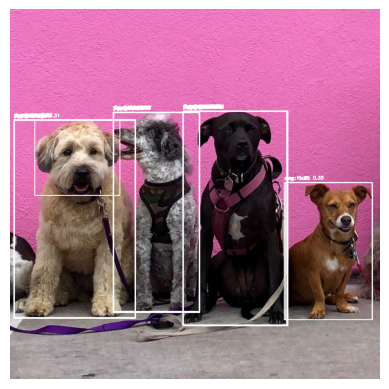

In [8]:
import random
import time  # Import time for measuring execution time
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline

@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box

        # Only annotate if the score is above the threshold
        if score > 0.3:
            # Set color to white
            color = (255, 255, 255)

            # Draw bounding box
            cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color, 2)
            cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: List[DetectionResult]) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-base"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    # Ensure all labels end with a period
    labels = [label if label.endswith(".") else label + "." for label in labels]

    results = object_detector(image, candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def grounded_segmentation(
    image: Union[Image.Image, str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, common_labels, threshold, detector_id)

    return np.array(image), detections

# List of common labels to search for in the image
common_labels = [
    "cat", "dog", "car", "tree", "person", "building",
    'leaf', 'insect', 'bird', 'fish', 'bicycle', 'horse', 
    'apple', 'orange', 'banana', 'computer', 'chair', 
    'table', 'phone', 'book', 'cup', 'clock', 
    'guitar', 'piano', 'hat', 'shoe', 'shirt', 
    'pants', 'dress', 'skirt', 'jacket', 'socks', 
    'umbrella', 'backpack', 'bottle', 'toothbrush', 
    'toothpaste', 'ball', 'balloon', 'kite', 'teddy bear', 
    'couch', 'bed', 'television', 'fridge', 'oven', 
    'sink', 'stove', 'mirror', 'window', 'door', 
    'cat food', 'dog food', 'fish food', 'paintbrush', 
    'camera', 'scissors', 'comb', 'basket', 'light bulb',
    'motorcycle', 'train', 'airplane', 'bus', 'boat', 
    'squirrel', 'elephant', 'lion', 'tiger', 'bear', 
    'zebra', 'giraffe', 'panda', 'koala', 'rabbit', 
    'turtle', 'crocodile', 'shark', 'whale', 'octopus', 
    'spider', 'snake', 'frog', 'ant', 'beetle', 
    'butterfly', 'caterpillar', 'ladybug', 'cockroach', 'mosquito',
    'peach', 'grape', 'kiwi', 'melon', 'plum',
    'lettuce', 'spinach', 'carrot', 'potato', 'onion',
    'garlic', 'pepper', 'tomato', 'cucumber', 'eggplant',
    'radish', 'pumpkin', 'cabbage', 'cauliflower', 'broccoli',
    'cereal', 'rice', 'bread', 'cookie', 'cake',
    'pizza', 'pasta', 'noodle', 'sandwich', 'hamburger',
    'hot dog', 'ice cream', 'juice', 'milk', 'coffee',
    'tea', 'soda', 'wine', 'beer', 'cocktail',
    'bookcase', 'desk', 'pencil', 'pen', 'notebook',
    'stapler', 'paperclip', 'folder', 'envelope', 'calendar'
]

# Path to the image
image_url = "dataset-card.jpg"
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-base"

# Measure the time taken for the detection process
start_time = time.time()

# Perform grounded segmentation
image_array, detections = grounded_segmentation(
    image=image_url,
    threshold=threshold,
    detector_id=detector_id
)

# Calculate the time taken
time_taken = time.time() - start_time
print(f"Time taken for detection: {time_taken:.2f} seconds")

# Plot the detections
plot_detections(image_array, detections)